## data読み込み

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os
import random

random_state = 623

In [95]:
def load_file(files,Soldiers):
    """ファイルを読み込んでnumpy.arrayに変換する関数
    
    Args:
    files : 読み込むファイルのリスト
    Soldiers : セーラー戦士のリスト
    
    Returns:
    np.array(file_list) : 読み込んだ画像のnumpy.array
    y : 正解ラベル
    """
    file_list = []
    y=[]
    for file in files:
        # 正解ラベルをリストに代入
        for i,soldier in enumerate(Soldiers):
            if soldier in file:
                y.append(i)
                
        # load img
        f = cv2.imread(file)
        f = cv2.resize(f, dsize=(128, 128))
        f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
        
        file_list.append(f)
    return np.array(file_list),y

In [96]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Soldiers = ["Sailorjupiter","Sailormars","Sailormercury","Sailormoon","Sailorneptune",
            "Sailorpluto","Sailorsaturn","Sailortibimoon","Sailoruranus","Sailorvenus"]

train_path = "./train/"
test_path = "./test/"
# load data
train,y_train = load_file(glob.glob(train_path+"/*"),Soldiers)
test,y_test = load_file(glob.glob(test_path+"/*"),Soldiers)

train = train.reshape((train.shape[0], 128, 128, 3)) / 255
x_test = test.reshape((test.shape[0], 128, 128, 3)) / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train, x_valid, y_train, y_valid = train_test_split(
    train, y_train,test_size=0.2,random_state=random_state)

## サンプルをいくつか表示

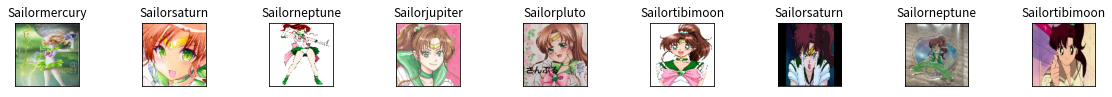

In [97]:
fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=1.0)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(train[i])
    for j in range(9):
        if y_train[i][j]==1:
            ax.set_title(Soldiers[j])

In [5]:
# train,valid,testのshapeを確認
print(x_train.shape)
print(y_train.shape)
print(x_valid.shape)
print(y_valid.shape)
print(x_test.shape)
print(y_test.shape)

(640, 128, 128, 3)
(640, 10)
(160, 128, 128, 3)
(160, 10)
(200, 128, 128, 3)
(200, 10)


## 転移学習モデルを生成

In [6]:
import keras
import tensorflow as tf
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Input

# base model(Xception)を読み込み
# include_top : 出力層側の3つのDenseを含むかどうか
base_model =  tf.keras.applications.xception.Xception(weights='imagenet',include_top=False,input_tensor=Input(shape=(224,224,3)))

# base modelに出力層を追加
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation="relu")(x)
prediction=Dense(10,activation='softmax')(x)
model=Model(inputs=base_model.input,outputs=prediction)
    
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer="adam",
    metrics=["accuracy"]
)

## 学習

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

train_datagen=ImageDataGenerator(
    width_shift_range=0.4, # 左にシフトする割合
    height_shift_range=0.4, # 垂直方向にシフトする割合
    rotation_range=30, # ランダムに30度の範囲で回転
    shear_range=0.2, # 反時計回りの回転
    zoom_range=0.2, # 拡大
    horizontal_flip=True) # 水平方向に反転

validation_datagen=ImageDataGenerator()

train_datagen.fit(x_train)
validation_datagen.fit(x_valid)

train_generator=train_datagen.flow(
    x_train,y_train,
    batch_size=70,
    shuffle=True
)

validation_generator=validation_datagen.flow(
    x_valid,y_valid,
    batch_size=70,
    shuffle=True
)

early_stopping = EarlyStopping(patience=70, verbose=1)

hist=model.fit_generator(train_generator,
                         epochs=300,
                         verbose=1,
                         validation_data=validation_generator,
                         callbacks=[early_stopping])

C:\Users\yudai\anaconda3\envs\py38-gpu\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/300
10/10 [==============================] - 12s 576ms/step - loss: 2.3452 - accuracy: 0.1152 - val_loss: 2.3200 - val_accuracy: 0.1063
Epoch 2/300
10/10 [==============================] - 4s 353ms/step - loss: 2.3026 - accuracy: 0.0911 - val_loss: 2.3105 - val_accuracy: 0.0812
Epoch 3/300
10/10 [==============================] - 4s 352ms/step - loss: 2.3014 - accuracy: 0.1150 - val_loss: 2.3112 - val_accuracy: 0.0812
Epoch 4/300
10/10 [==============================] - 4s 339ms/step - loss: 2.3014 - accuracy: 0.1228 - val_loss: 2.3139 - val_accuracy: 0.0812
Epoch 5/300
10/10 [==============================] - 4s 336ms/step - loss: 2.3004 - accuracy: 0.1234 - val_loss: 2.3200 - val_accuracy: 0.0938
Epoch 6/300
10/10 [==============================] - 4s 353ms/step - loss: 2.2991 - accuracy: 0.0968 - val_loss: 2.3437 - val_accuracy: 0.0688
Epoch 7/300
10/10 [==============================] - 4s 357ms/step - loss: 2.3002 - accuracy: 0.1318 - val_loss: 2.4598 - val_accuracy: 0.068

Epoch 58/300
10/10 [==============================] - 4s 337ms/step - loss: 0.5157 - accuracy: 0.8392 - val_loss: 3.9616 - val_accuracy: 0.5688
Epoch 59/300
10/10 [==============================] - 4s 336ms/step - loss: 0.4876 - accuracy: 0.8457 - val_loss: 2.8740 - val_accuracy: 0.6250
Epoch 60/300
10/10 [==============================] - 4s 342ms/step - loss: 0.4387 - accuracy: 0.8730 - val_loss: 1.6540 - val_accuracy: 0.7563
Epoch 61/300
10/10 [==============================] - 4s 341ms/step - loss: 0.3421 - accuracy: 0.8762 - val_loss: 6.4172 - val_accuracy: 0.5188
Epoch 62/300
10/10 [==============================] - 4s 347ms/step - loss: 0.4862 - accuracy: 0.8397 - val_loss: 46.4308 - val_accuracy: 0.2875
Epoch 63/300
10/10 [==============================] - 4s 336ms/step - loss: 0.3911 - accuracy: 0.8857 - val_loss: 21.3072 - val_accuracy: 0.2875
Epoch 64/300
10/10 [==============================] - 4s 342ms/step - loss: 0.3970 - accuracy: 0.8625 - val_loss: 5.0521 - val_accurac

Epoch 115/300
10/10 [==============================] - 4s 340ms/step - loss: 0.2860 - accuracy: 0.9132 - val_loss: 1.5694 - val_accuracy: 0.7875
Epoch 116/300
10/10 [==============================] - 3s 369ms/step - loss: 0.2783 - accuracy: 0.9266 - val_loss: 0.8429 - val_accuracy: 0.7875
Epoch 117/300
10/10 [==============================] - 4s 378ms/step - loss: 0.2729 - accuracy: 0.9217 - val_loss: 0.8787 - val_accuracy: 0.7750
Epoch 118/300
10/10 [==============================] - 4s 346ms/step - loss: 0.1926 - accuracy: 0.9555 - val_loss: 1.5984 - val_accuracy: 0.6875
Epoch 119/300
10/10 [==============================] - 4s 341ms/step - loss: 0.2781 - accuracy: 0.9157 - val_loss: 1.0906 - val_accuracy: 0.7875
Epoch 120/300
10/10 [==============================] - 4s 343ms/step - loss: 0.2518 - accuracy: 0.9274 - val_loss: 0.7738 - val_accuracy: 0.8250
Epoch 121/300
10/10 [==============================] - 4s 341ms/step - loss: 0.2495 - accuracy: 0.9271 - val_loss: 0.8228 - val_ac

10/10 [==============================] - 3s 325ms/step - loss: 0.1299 - accuracy: 0.9630 - val_loss: 1.2454 - val_accuracy: 0.7563
Epoch 172/300
10/10 [==============================] - 4s 341ms/step - loss: 0.1548 - accuracy: 0.9569 - val_loss: 0.6069 - val_accuracy: 0.8625
Epoch 173/300
10/10 [==============================] - 4s 342ms/step - loss: 0.1158 - accuracy: 0.9714 - val_loss: 0.6199 - val_accuracy: 0.8687
Epoch 174/300
10/10 [==============================] - 4s 340ms/step - loss: 0.1074 - accuracy: 0.9727 - val_loss: 0.6246 - val_accuracy: 0.8813
Epoch 175/300
10/10 [==============================] - 4s 344ms/step - loss: 0.1272 - accuracy: 0.9577 - val_loss: 0.8684 - val_accuracy: 0.7937
Epoch 176/300
10/10 [==============================] - 4s 339ms/step - loss: 0.1256 - accuracy: 0.9666 - val_loss: 0.8142 - val_accuracy: 0.7812
Epoch 177/300
10/10 [==============================] - 4s 340ms/step - loss: 0.1341 - accuracy: 0.9655 - val_loss: 0.6132 - val_accuracy: 0.8125

## 正解率, 損失関数を確認

In [8]:
def plot_loss(history):
    """エポックごとの損失関数をプロットする関数
    
    Args:
    history : fittingの履歴
    
    Returns:
    None
    """
    # 損失関数の履歴を取得
    loss_train = history.history["loss"]
    loss_val = history.history["val_loss"]

    # 損失関数をプロット
    epochs=range(1,len(history.history["loss"])+1)
    plt.figure(facecolor="white")
    plt.plot(epochs,loss_train,label="Training loss")
    plt.plot(epochs,loss_val,label="Validation loss")
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
def plot_acc(history):
    """エポックごとの正解率をプロットする関数
    
    Args:
    history : fittingの履歴
    
    Returns:
    None
    """
    acc_train = history.history['accuracy']
    acc_val = history.history['val_accuracy']
    epochs = range(1,len(history.history["accuracy"])+1)
    plt.figure(facecolor="white")
    plt.plot(epochs, acc_train, 'g', label='Training accuracy')
    plt.plot(epochs, acc_val, 'b', label='Validation accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

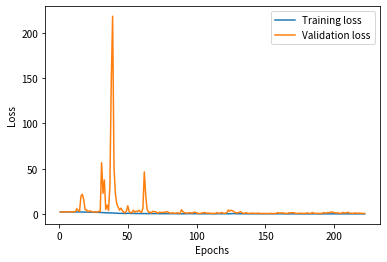

In [9]:
# 損失関数の描画
plot_loss(hist)

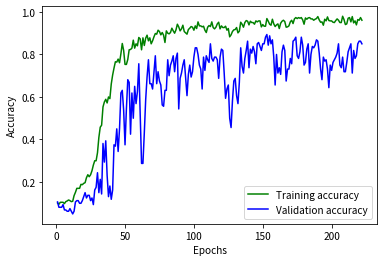

In [10]:
# 正解率を描画
plot_acc(hist)

## テストデータによる評価

In [39]:
# modelの評価
test_datagen=ImageDataGenerator()
test_datagen.fit(x_test)
test_generator=test_datagen.flow(
    x_test,y_test,
    batch_size=100,
    shuffle=False
)

scores = model.evaluate(test_generator)
prediction = model.predict(test_generator)
prediction_label = np.argmax(model.predict(test_generator),axis=1)

2/2 [==============================] - 0s 96ms/step - loss: 0.8476 - accuracy: 0.8000


<ipython-input-101-b4449feba43f>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  test = np.array(file_list)


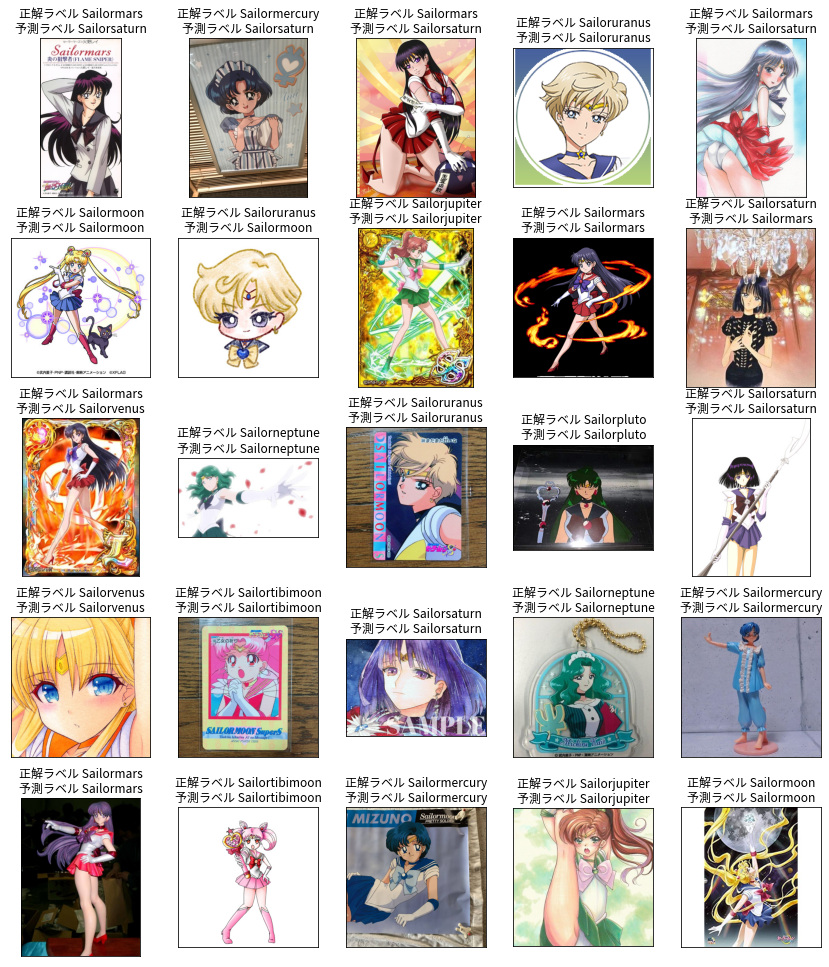

In [101]:
files=glob.glob(test_path+"/*")
file_list = []
y_label = []
for file in files:
    # 正解ラベルをリストに代入
    for i,soldier in enumerate(Soldiers):
        if soldier in file:
            y_label.append(i)
    # load img
    f = cv2.imread(file)
    f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
    file_list.append(f)
test = np.array(file_list)

r =np.array(random.sample(range(0,200),25)).reshape(5,5)

fig = plt.figure(figsize=(15, 15))
k=1
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,k)
        plt.imshow(test[r[i][j]])
        k+=1
        plt.xticks([]),plt.yticks([])
        plt.title("正解ラベル "+Soldiers[y_label[r[i][j]]]+"\n予測ラベル "+Soldiers[prediction_label[r[i][j]]])
        
plt.subplots_adjust(left=0.2, right=0.95, bottom=0.1, top=0.95)
plt.show()

<AxesSubplot:>

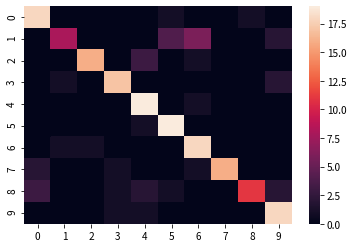

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_label, prediction_label)
sns.heatmap(cm)